# Building a Supervised Machine Learning Model

The objective of this hands-on activity is to create and evaluate a Real-Bogus classifier using ZTF alert data.  We will use the same data from the Day 2 clustering exercise (see [that notebook](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session7/Day2/Clustering-Astronomical-Sources.ipynb) to download the data).  

1. Load data
2. Examine features
3. Curate a test and training set
4. Train classifiers
5. Compare the performance of different learning algorithms

#### What's Not Covered

There are many topics to cover, and due to time constraints, we cannot cover them all.  Omitted is a discussion of [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) and [hyperparameter tuning](http://scikit-learn.org/stable/modules/grid_search.html).  I encourage you to click through and read those articles by sklearn.

### 0a. Imports

These are all the imports that will be used in this notebook.  All should be available in the DSFP conda environment.

In [1]:
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### 0b. Data Location

Please specify paths for the following:

In [2]:
F_META = '../Day2/dsfp_ztf_meta.npy'
F_FEATS = '../Day2/dsfp_ztf_feats.npy'
D_STAMPS = '../Day2/dsfp_ztf_png_stamps'

# 1. Load Data

Please note that I have made some adjustments to the data.  

- I have created a dataframe (feats_df) from feats_np
- I have also dropped columns from feats_df.  Some were irrelevant to classification, and some contained a lot of NaNs.

In [51]:
meta_np = np.load(F_META)
feats_np = np.load(F_FEATS)

COL_NAMES = ['diffmaglim', 'magpsf', 'sigmapsf', 'chipsf', 'magap', 'sigmagap',
             'distnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr', 'sky',
             'magdiff', 'fwhm', 'classtar', 'mindtoedge', 'magfromlim', 'seeratio',
             'aimage', 'bimage', 'aimagerat', 'bimagerat', 'elong', 'nneg',
             'nbad', 'ssdistnr', 'ssmagnr', 'sumrat', 'magapbig', 'sigmagapbig',
             'ndethist', 'ncovhist', 'jdstarthist', 'jdendhist', 'scorr', 'label']

# NOTE FROM Umaa: I've decided to eliminate the following features. Dropping them.
#
COL_TO_DROP = ['ndethist', 'ncovhist', 'jdstarthist', 'jdendhist', 
               'distnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr', 
               'classtar', 'ssdistnr', 'ssmagnr', 'aimagerat', 'bimagerat', 
               'magapbig', 'sigmagapbig', 'scorr']
feats_df = pd.DataFrame(data=feats_np, index=meta_np['candid'], columns=COL_NAMES)
print("There are {} columns left.".format(len(feats_df.columns)))
print("They are: {}".format(list(feats_df.columns)))
feats_df.drop(columns=COL_TO_DROP, inplace=True) 
feats_df.describe()

There are 36 columns left.
They are: ['diffmaglim', 'magpsf', 'sigmapsf', 'chipsf', 'magap', 'sigmagap', 'distnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr', 'sky', 'magdiff', 'fwhm', 'classtar', 'mindtoedge', 'magfromlim', 'seeratio', 'aimage', 'bimage', 'aimagerat', 'bimagerat', 'elong', 'nneg', 'nbad', 'ssdistnr', 'ssmagnr', 'sumrat', 'magapbig', 'sigmagapbig', 'ndethist', 'ncovhist', 'jdstarthist', 'jdendhist', 'scorr', 'label']


,diffmaglim,magpsf,sigmapsf,chipsf,magap,sigmagap,sky,magdiff,fwhm,mindtoedge,magfromlim,seeratio,aimage,bimage,elong,nneg,nbad,sumrat,label
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000
mean,20.151915,19.038766,0.114721,29.171392,18.882236,0.133377,1.759273,-0.156530,5.762724,535.662895,1.269680,-19.033703,1.447092,1.121355,1.277802,3.702508,0.827586,0.942922,0.263636
std,0.600403,1.182225,0.059628,184.693580,1.146221,0.090430,11.922192,0.361237,8.082798,358.128782,1.056042,140.283975,1.359441,1.081769,0.233597,2.640393,1.852272,0.093331,0.440673
min,16.387886,11.861366,0.000729,0.145480,11.904000,0.000900,-62.988770,-0.999049,-0.840000,10.071900,-0.689344,-999.000000,0.289000,0.256000,1.000000,0.000000,0.000000,0.400054,0.000000
25%,19.816405,18.404491,0.066442,1.752059,18.243625,0.062925,-0.078796,-0.387930,2.080000,233.525776,0.485384,0.392570,0.771250,0.667000,1.096764,2.000000,0.000000,0.921823,0.000000
50%,20.221339,19.230843,0.111248,3.588183,19.093750,0.121900,0.326771,-0.088569,3.170000,475.807602,1.019777,0.794723,1.018000,0.841000,1.201702,3.000000,0.000000,0.990973,0.000000
75%,20.608219,19.917913,0.167752,11.765462,19.744100,0.185475,0.891043,0.057932,6.200000,782.824844,1.860215,1.171276,1.726750,1.268000,1.395918,5.000000,0.000000,1.000000,1.000000
max,21.169477,21.312767,0.217133,7037.184570,21.160299,0.733300,321.040314,0.971744,118.790001,1507.777222,8.407010,116.662155,23.407000,15.154000,2.000000,13.000000,7.000000,1.000000,1.000000


In [5]:
feats_df.shape

(3190, 19)

In [8]:
# INSTRUCTION: How many real and bogus examples are in this labeled set
#
n_real = len(feats_df.query('label == 1'))
n_bogus = len(feats_df.query('label == 0'))

print('There are {} real samples and {} bogus ones'.format(n_real, n_bogus))

There are 841 real samples and 2349 bogus ones


## 2. Plot Features

Examine each individual feature. You may use the subroutine below, or code of your own devising. Note the features that are continuous vs categorial, and those that have outliers.  There are certain features that have sentinel values.  You may wish to view some features on a log scale.

#### Question: Which features seem to have pathologies? Which features should we exclude?

In [22]:
# Histogram a Single Feature
#
def plot_rb_hists(df, colname, bins=100, xscale='linear', yscale='linear'):
    mask_real = feats_df['label'] == 1
    mask_bogus = ~mask_real
    plt.hist(df[colname][mask_real], bins, color='b', alpha=0.5, density=True, label = 'real')
    plt.hist(df[colname][mask_bogus], bins, color='r', alpha=0.5, density=True, label = 'bogus')
    plt.legend()
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(colname)
    plt.show()
    

# INSTRUCTION: Plot the individual features.  
#


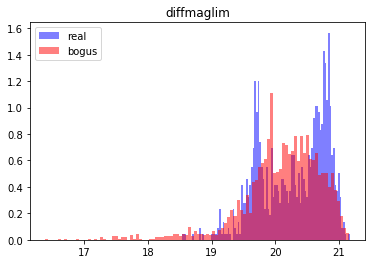

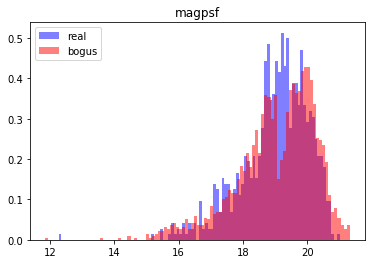

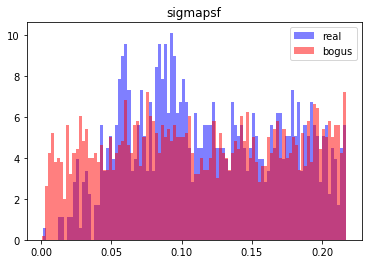

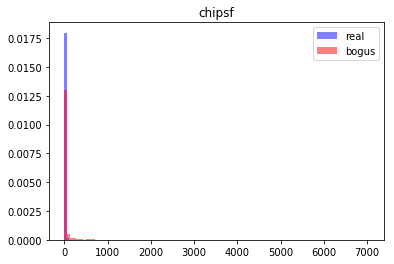

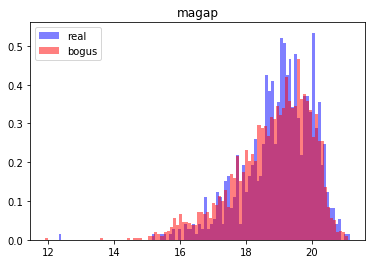

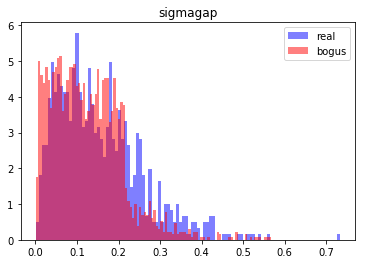

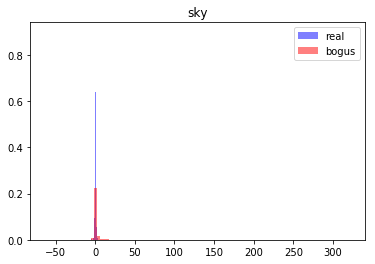

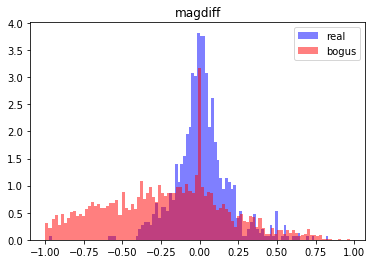

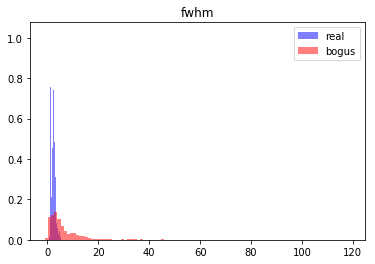

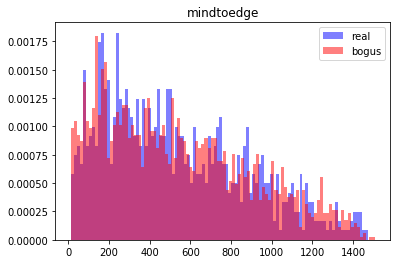

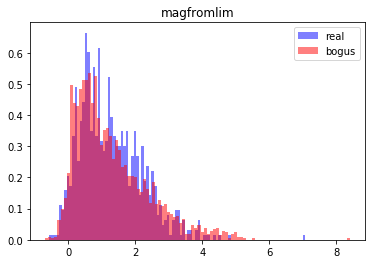

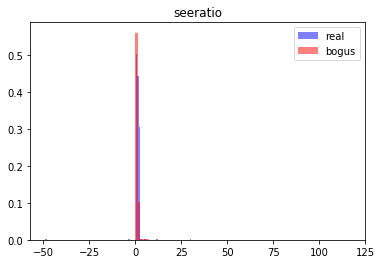

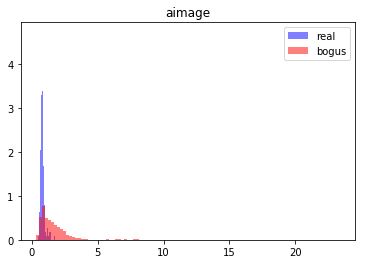

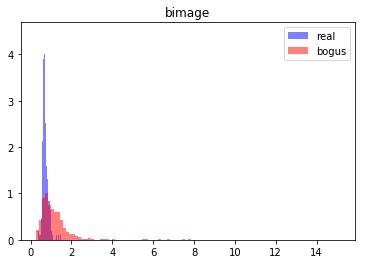

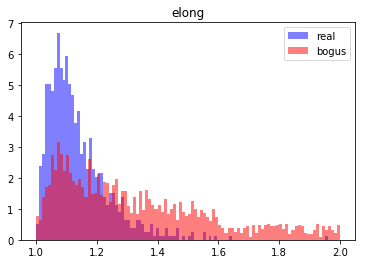

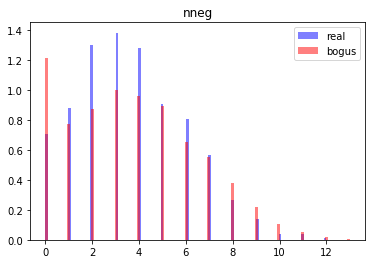

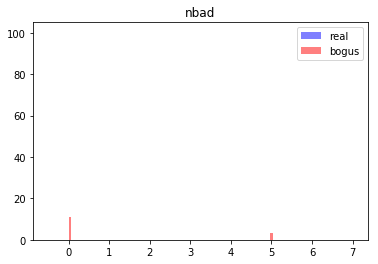

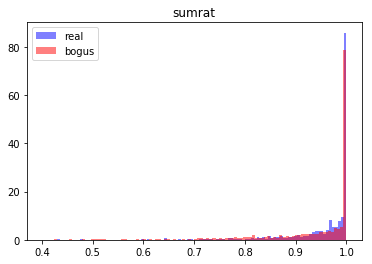

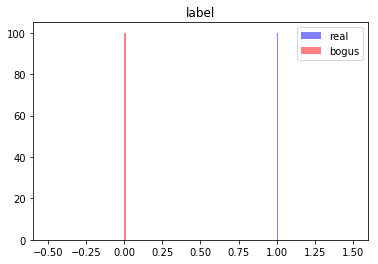

In [39]:
# Histograms for every feature
for feat in list(feats_df):
    plot_rb_hists(feats_df, feat)

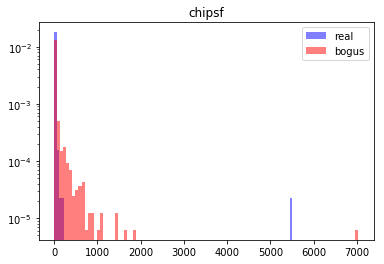

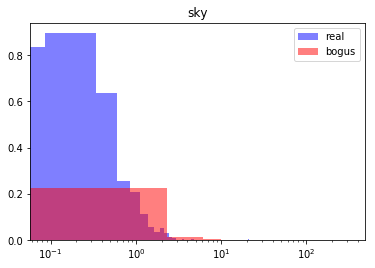

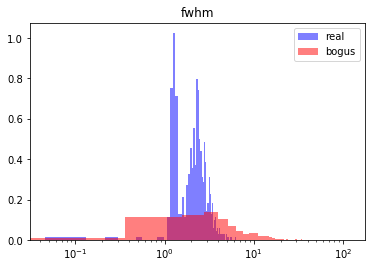

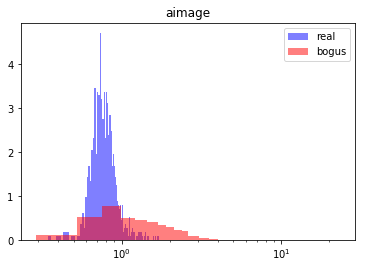

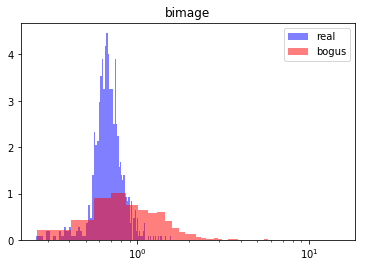

In [41]:
# Historgrams for features changing scales

plot_rb_hists(feats_df, 'chipsf', bins=100, yscale='log')
plot_rb_hists(feats_df, 'sky', bins=100, xscale='log', )
plot_rb_hists(feats_df, 'fwhm', bins=100, xscale='log', )
plot_rb_hists(feats_df, 'aimage', bins=100, xscale='log', )
plot_rb_hists(feats_df, 'bimage', bins=100, xscale='log', )

#### Answer: 

- 'nbad' and 'nneg' are discrete features
- 'seeratio' has a sentinel value of -999
- There are some features that have high ranges than others.  For classifiers that are sensitive to scaling, we will need to scale the data
- There does not appear to be good separability between real and bogus on any individual features.

## 3. Curate a Test and Training Set

We need to reserve some of our labeled data for evaluation. This means we must split up the labeled data we have into the set used for training (training set), and the set used for evaluation (test set). Ideally, the distribution of real and bogus examples in both the training and test sets are roughly identical. One can use sklearn.model_selection.train_test_split and use the stratify option.

For ZTF data, we split the training and test data by date. That way repeat observations from the same night (which might be nearly identical) cannot be split into the training and test set, and artificially inflate test performance. Also, due to the change in survey objectives, it's possible that the test set features have drifted away from the training sets.

Provided is nid.npy which contains the Night IDs for ZTF. Split on nid=550 (July 5, 2018). This should leave you with roughly 500 examples in your test set.


In [62]:
feats_plus_label = np.array(feats_df)
nids = meta_np['nid']

# INSTRUCTION: nid.npy contains the nids for this labeled data.
# Split the data into separate data structures for train/test data at nid=500.
# Verify that you have at least 500 reals in your test set.

train = feats_df.iloc[np.where(nids <= 550)]
test = feats_df.iloc[np.where(nids > 550)]

In [67]:
print('Test set has {} samples\nTrain set has {} samples'.format(len(test), len(train)))
print('Test set is {} samples\nTrain set is {} samples'.format(len(test)/len(feats_df) * 100, len(train)/len(feats_df) * 100))

Test set has 604 samples
Train set has 2522 samples
Test set is 18.934169278996865 samples
Train set is 79.05956112852664 samples


In [64]:
# Now, we should get rid of seeratio -999

train = train.query('seeratio > -900')

In [66]:
print('Test set has {} samples\nTrain set has {} samples'.format(len(test), len(train)))

Test set has 604 samples
Train set has 2522 samples


## 4. Train a Classifier

#### Part 1: Separate Labels from the Features

Now store the labels separately from the features.  

In [71]:
# INSTRUCTION: Separate the labels from the features

train_X = train.iloc[:,:-1]
train_y = train.label
test_X = test.iloc[:,:-1]
test_y = test.label

#### Part 2. Scaling Data

With missing values handled, you're closing to training your classifiers.  However, because distance metrics can be sensitive to the scale of your data (e.g., some features span large numeric ranges, but others don't), it is important to normalize data within a standard range such as (0, 1) or with z-score normalization (scaling to unit mean and variance).  Fortunately, sklearn also makes this quite easy.  Please review sklearn's [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) module options, specifically StandardScaler which corresponds to z-score normalization and MinMaxScaler.  Please implement one.  

FYI - Neural networks and Support Vector Machines (SVM) are sensitive to the scale of the data.  Decision trees (and therefore Random Forests) are not (but it doesn't hurt to use scaled data).

In [79]:
# INSTRUCTION: Re-scale your data using either the MinMaxScaler or StandardScaler from sklearn
#
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X) 
test_X_scaled = scaler.fit_transform(test_X)

In [80]:
train_X_scaled.shape

(2522, 18)

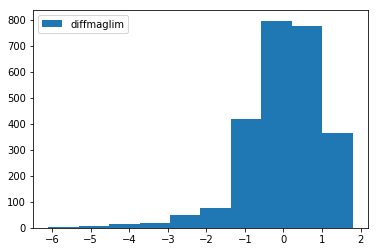

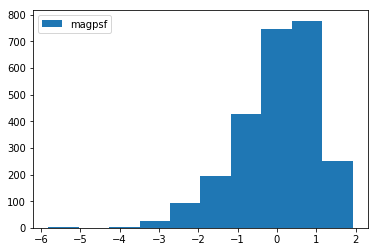

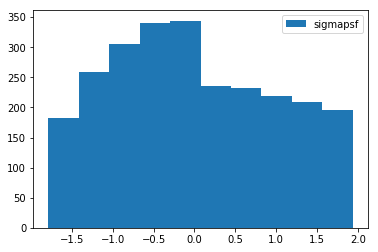

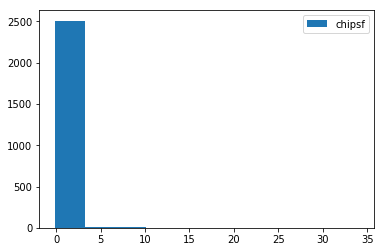

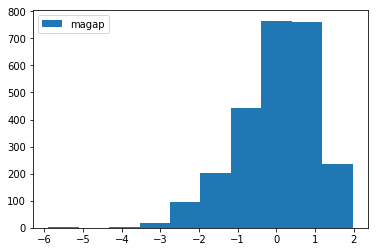

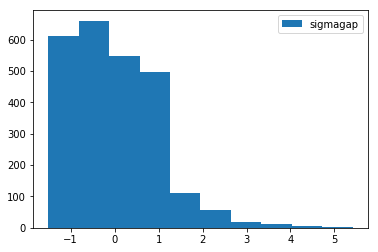

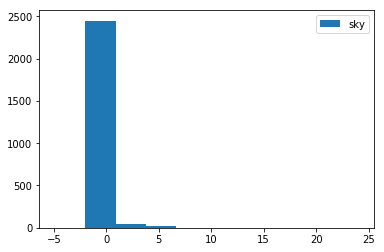

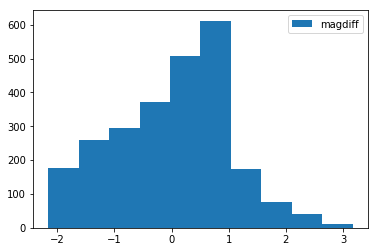

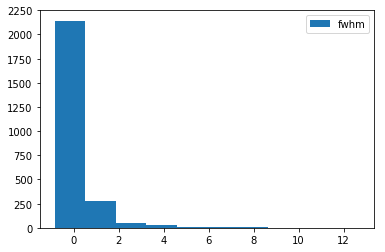

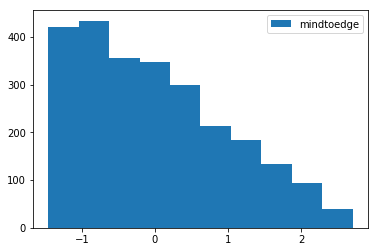

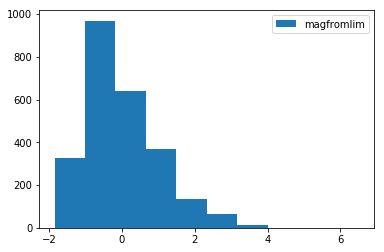

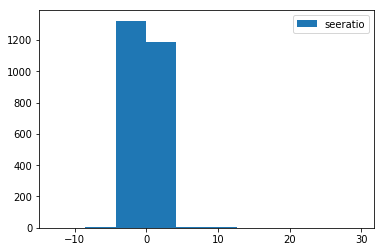

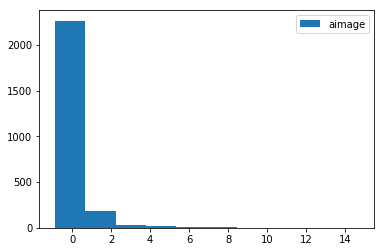

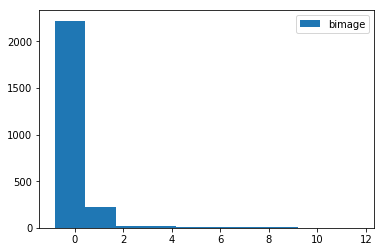

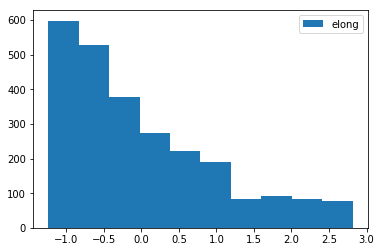

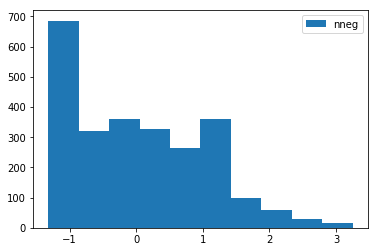

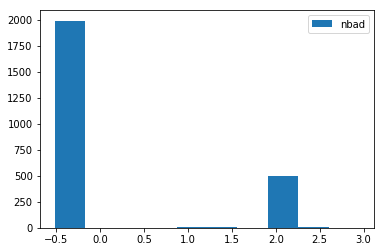

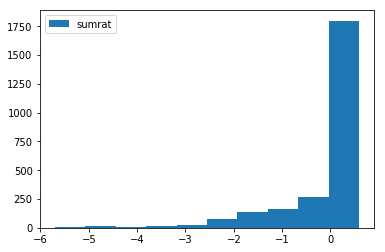

In [83]:
for i in range(len(list(train_X))):
    plt.hist(train_X_scaled[:,i], label = list(train_X)[i])
    plt.legend()
    plt.show()

#### Part 3. Train Classifiers

Import a few classifiers and build models on your training data.  Some suggestions include a [Support Vector Machine](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier), [Neural Net](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier), [NaiveBayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) and [K-Nearest Neighbor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).  

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

#knn3 = KNeighborsClassifier(3),
#svml = SVC(kernel="linear", C=0.025, probability=True)
#svmr = SVC(gamma=2, C=1, probability=True)
#dtre = DecisionTreeClassifier()
#rafo = RandomForestClassifier(n_estimators=100)
#nnet = MLPClassifier(alpha=1)
#naiv = GaussianNB()

# INSTRUCTION: Train at least three classifiers and run on your test data. Here's an example to get your started.  
# 


#rafo.fit(train_feats, train_labels)
#rafo_scores = rafo.predict_proba(test_feats)[:,1]


# INSTRUCTION: Print out the following metrics per classifier into a table: accuracy, auc, f1_score, etc.
# 

In [96]:
# kNN

from sklearn.neighbors import KNeighborsClassifier

knn3 = KNeighborsClassifier(3)

knn3.fit(train_X, train_y)
knn3_scores = knn3.predict_proba(test_X) # Probability of belonging to the second class
knn3_class = knn3.predict(test_X)

In [113]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

dtre = DecisionTreeClassifier()

dtre.fit(train_X, train_y)
dtre_scores = dtre.predict_proba(test_X) # Probability of belonging to the second class
dtre_class = dtre.predict(test_X)

In [114]:
# Gaussian NB

from sklearn.naive_bayes import GaussianNB

naiv = GaussianNB()

naiv.fit(train_X, train_y)
naiv_scores = naiv.predict_proba(test_X) # Probability of belonging to the second class
naiv_class = naiv.predict(test_X)

In [115]:
# NNet

from sklearn.neural_network import MLPClassifier

nnet = MLPClassifier(alpha=1)

nnet.fit(train_X, train_y)
nnet_scores = nnet.predict_proba(test_X) # Probability of belonging to the second class
nnet_class = nnet.predict(test_X)

In [106]:
# Metrics
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

def metric_table(classifier, y_pred, y_true):
    acc = accuracy_score(y_true, y_pred) 
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('{}\t\t{}\t{}\t{}'.format(classifier,acc, auc, f1))

In [118]:
# Table of metrics

print(82 * '_')
print('classifier\t\taccuracy\tauc\tf1 score')
metric_table('kNN(3)', test_y, knn3_class)
metric_table('DecTree', test_y, dtre_class)
metric_table('GaussNB', test_y, naiv_class)
metric_table('NNet', test_y, nnet_class)

__________________________________________________________________________________
classifier		accuracy	auc	f1 score
kNN(3)		0.5927152317880795	0.5850409836065573	0.51953125
DecTree		0.6423841059602649	0.6431548010703162	0.6236933797909407
GaussNB		0.49503311258278143	0.7186488351111819	0.636471990464839
NNet		0.6721854304635762	0.7023910984848485	0.696319018404908


#### Part 4. Plot Real and Bogus Score Distributions

Another way to test performance is to plot a histogram of the test set RB scores, comparing the distributions of the labeled reals vs. boguses.  The scores of the reals should be close to 1, while the scores of the boguses should be closer to 0.  The more separated the distribution of scores, the better performing your classifier is.

Compare the score distributions of the classifiers you've trained.  Trying displaying as a cumulative distribution rather than straight histogram.  

*Optional:* What would the decision thresholds be at the  5% false negative rate (FNR)?  What would the decision threshold be at the 1% false positive rate?

In [ ]:
# INSTRUCTION: create masks for the real and bogus examples of the test set
real_test = test_y.iloc[np.where(test_y == 1)]
bogus_test = test_y.iloc[np.where(test_y == 0)]

# INSTRUCTION: First compare the classifiers' scores on the test reals only
#

scores_list = []
legends = ['Classifier 1', 'Classifier 2', 'Classifier 3'] # REPLACE ME
colors = ['g', 'b', 'r'] 
rbbins = np.arange(0,1,0.001)

# Comparison on real examples

plt.figure()
ax = plt.subplot(111)
for i, scores in enumerate(scores_list):
    # ax.hist() - COMPLETE ME
ax.set_xlabel('RB Score')
ax.set_ylabel('Count')
ax.set_xbound(0, 1)
ax.legend(legends, loc=4)
plt.show()


# Now perform the same comparison on bogus examples
#

## Refining

Now it's time to go back and start experimenting with different parameters.  If you have time, create a validation set and perform a Grid Search over a set of possible hyperparameters.  Compare different classifier results using the histograms above.